# Importing Packages

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preprocessing

In [2]:
data_dir = pathlib.Path('C:/Users/Blake/Downloads/Shoes Dataset') # defining the path to the dataset

In [3]:
# splitting the dataset into a training set
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 80% of the data will be used for training
    subset = 'training',
    seed = 123, # ensures random partitioning
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 128 # images to be processed at a time
)

Found 10500 files belonging to 6 classes.
Using 8400 files for training.


In [4]:
# splitting the dataset into a validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 20% of the data will be used for validating
    subset = 'validation',
    seed = 123, # having the same random seed ensures samples don't appear in both sets
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 128 # images to be processed at a time
)

Found 10500 files belonging to 6 classes.
Using 2100 files for validation.


# Model Architecture

In [5]:
class_labels = training_set.class_names # getting the class labels of the dataset

In [6]:
resnet_model = Sequential() # creating a sequential model

# loading a pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    include_top = False, # excluding the final classification layer of the original model
    input_shape = (224, 224, 3), # expected input image shape (224x224 pixels and 3 colour schemes - RGB)
    pooling = 'avg', # global average pooling layer for feature aggregation
    classes = len(class_labels), # number of output classes to be expected
    weights = 'imagenet' # initialise the pre-trained weights from the ImageNet dataset
)

# setting all layers in the pre-trained model to be non-trainable helps reduce training time
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten()) # transforms the 2D feature maps to a 1D vector
resnet_model.add(Dense(512, activation = 'relu')) # add 512 neurons and ReLU activation for feature transformation
resnet_model.add(Dropout(0.5)) # add dropout layer for regularisation to prevent overfitting
resnet_model.add(Dense(len(class_labels), activation = 'softmax')) # add a neuron for each output class and softmax activation for classification

In [7]:
# compiling the model
resnet_model.compile(
    optimizer = Adam(learning_rate = 0.001), # Adam optimiser and a learning rate of 0.001 for gradient descent
    loss = 'categorical_crossentropy', # compile the model with the categorical cross entropy loss function for multi-class classification
    metrics = ['accuracy'] # compile the model with the accuracy metric to monitor performance during training
)

In [8]:
# defining a learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# gradually decreases the learning rate each epoch after the 5th epoch
lr_scheduler = LearningRateScheduler(lr_schedule)

# stops fine-tuning the model if the validation loss increases for 5 epochs straight
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

# saves the best model during training
best_model_checkpoint = ModelCheckpoint(
    'best_resnet_model', # name of save 
    monitor = 'val_loss', # checkpoint criteria
    save_best_only = True, # saves the model with the highest validation accuracy
    save_weights_only = False, # saves the entire model
    save_format = 'tf' # saves the model as a Keras SavedModel format
)

# Fine-Tuning Model

In [9]:
# fine-tune the model and store training history
history = resnet_model.fit(
    training_set, # fine-tune the model on the training set
    validation_data = validation_set, # validate the model
    epochs = 10, # run over the training and validation sets 10 times
    callbacks = [lr_scheduler, early_stopping, best_model_checkpoint] # applying callbacks to model's fine-tuning
)

Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9302 INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 945s 14s/step - loss: 0.2472 - accuracy: 0.9302 - val_loss: 0.0056 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9979 INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 908s 13s/step - loss: 0.0100 - accuracy: 0.9979 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9990 INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 950s 14s/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0018 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9993 INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 922s 13s/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 7.1222e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 898s 13s/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 3.5123e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9999 INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 937s 14s/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 2.6288e-04 - val_accuracy: 1.0000 - lr: 9.0484e-04
Epoch 7/10
66/66 [==============================] - 893s 13s/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 5.8010e-04 - val_accuracy: 1.0000 - lr: 8.1873e-04
Epoch 8/10
66/66 [==============================] - ETA: 0s - loss: 8.9373e-04 - accuracy: 0.9999INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 908s 13s/step - loss: 8.9373e-04 - accuracy: 0.9999 - val_loss: 2.1912e-04 - val_accuracy: 1.0000 - lr: 7.4082e-04
Epoch 9/10
66/66 [==============================] - ETA: 0s - loss: 9.9470e-04 - accuracy: 1.0000INFO:tensorflow:Assets written to: best_resnet_model\assets


INFO:tensorflow:Assets written to: best_resnet_model\assets


66/66 [==============================] - 945s 14s/step - loss: 9.9470e-04 - accuracy: 1.0000 - val_loss: 1.7523e-04 - val_accuracy: 1.0000 - lr: 6.7032e-04
Epoch 10/10
66/66 [==============================] - 896s 13s/step - loss: 6.9571e-04 - accuracy: 0.9999 - val_loss: 2.2023e-04 - val_accuracy: 1.0000 - lr: 6.0653e-04


# Model Evaluation

In [12]:
# accessing the history object to get loss and accuracy values across each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

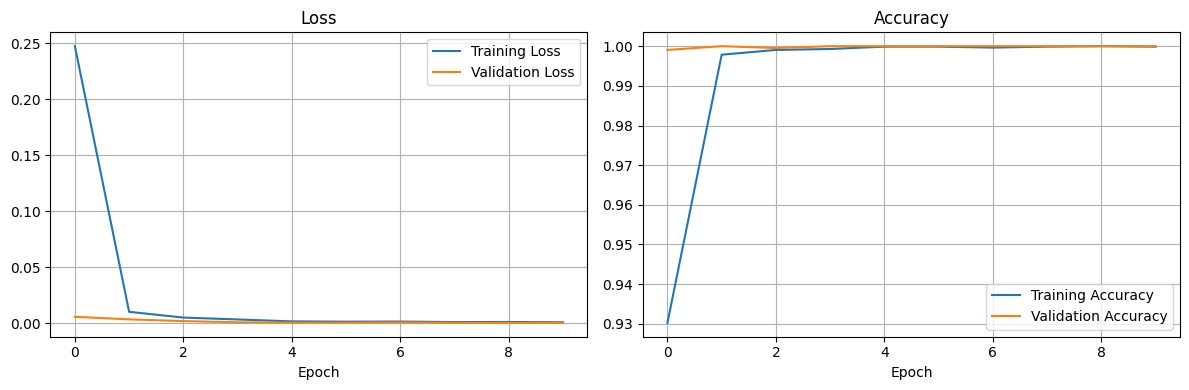

In [13]:
# creating subplots for loss and accuracy metrics
plt.figure(figsize = (12, 4))

# plotting training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# displaying the plots
plt.tight_layout()
plt.show()

In [14]:
# importing the best ResNet model
best_resnet_model = tf.keras.models.load_model('best_resnet_model')

In [15]:
# initialising lists to store true and predicted labels
true_labels = []
predicted_labels = []

# defining the path to the test images
test_dir = 'C:/Users/Blake/Downloads/Shoes Test Set'

# looping through each subfolder in the test directory
for subfolder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, subfolder)
    if os.path.isdir(subfolder_path):
        # extracting the true class label from the subfolder name
        true_class = subfolder

        # looping through each image in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.JPG'):
                # loading and preprocessing the image
                image = cv2.imread(os.path.join(subfolder_path, filename))
                image_resized = cv2.resize(image, (224, 224))
                image = np.expand_dims(image_resized, axis=0)

                # making prediction
                prediction = best_resnet_model.predict(image)
                predicted_class = class_labels[np.argmax(prediction)]

                # appending the true and predicted labels to the lists
                true_labels.append(true_class)
                predicted_labels.append(predicted_class)

1/1 [==============================] - 0s 487ms/step


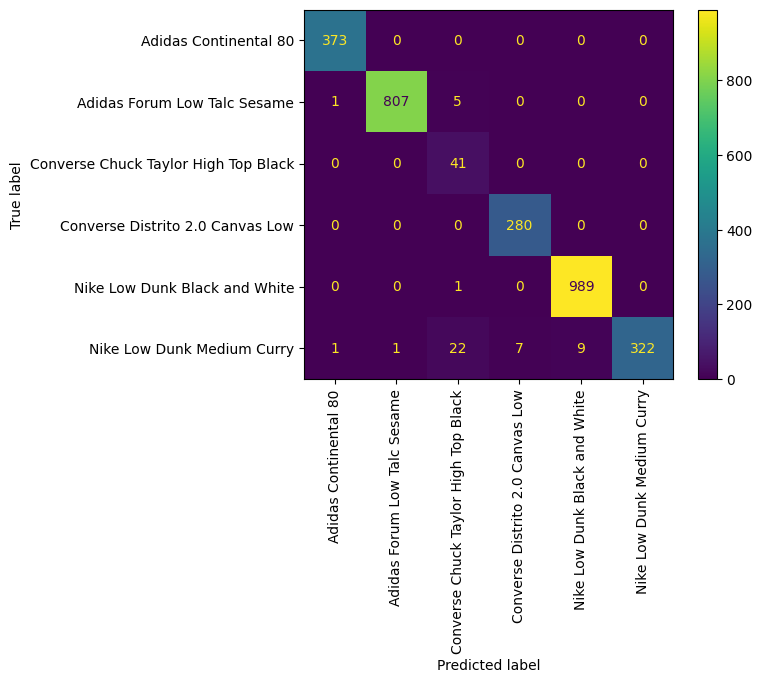

In [16]:
# creating a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels = class_labels)

# displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'viridis', xticks_rotation = 'vertical')
plt.show()

# Converting Model

In [15]:
# converting the best ResNet model from a Keras SavedModel format to TensorFlow Lite (TFLite) format
converter = tf.lite.TFLiteConverter.from_keras_model(best_resnet_model)
tflite_resnet_model = converter.convert()

# saving the TFLite model to a file
with open ('best_resnet_model.tflite', 'wb') as f:
  f.write(tflite_resnet_model)

INFO:tensorflow:Assets written to: C:\Users\Blake\AppData\Local\Temp\tmpcs1h0dnh\assets


INFO:tensorflow:Assets written to: C:\Users\Blake\AppData\Local\Temp\tmpcs1h0dnh\assets
